In [0]:
pip install -q sklearn

In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot  as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier 
%matplotlib inline

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:

x_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/dm-predict-h1n1/training_set_features.csv',sep=',',index_col="respondent_id")
y_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/dm-predict-h1n1/training_set_labels.csv',sep=',',index_col="respondent_id")
x_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/dm-predict-h1n1/test_set_features.csv',index_col="respondent_id")
x_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [28]:
# training features
print(x_train.info())
print(x_train.describe())
print(x_train.isnull().sum())

#training labels
print(y_train.describe())

#test features 
print(x_test.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [29]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   h1n1_vaccine      26707 non-null  int64
 1   seasonal_vaccine  26707 non-null  int64
dtypes: int64(2)
memory usage: 625.9 KB


# Exploring data

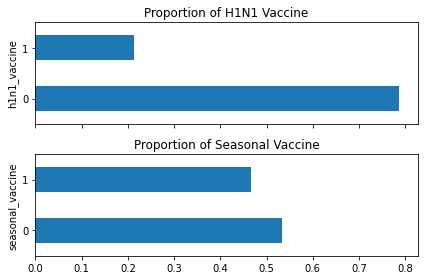

In [30]:
# First take a look at the two target variables
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = y_train.shape[0]

(y_train['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(y_train['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()
#evident that seasonal_vaccine class is balanced where as h1n1_vaccine class is imbalanced

In [31]:
print(pd.crosstab(
    y_train["h1n1_vaccine"], 
    y_train["seasonal_vaccine"], 
    margins=True,
    normalize=True
))

# Find the correlation between two target vars
# Phi Coefficient is the same as Pearson for two binary variables
print("\nCorrelation")
print(y_train["h1n1_vaccine"]
     .corr(y_train["seasonal_vaccine"], method="pearson")
)

print("These two variables have a phi coefficient of 0.37, indicating a moderate positive correlation. We can see that in the cross-tabulation as well. Most people who got an H1N1 flu vaccine also got the seasonal flu vaccine."+
      " \nWhile a minority of people who got the seasonal vaccine got the H1N1 vaccine, they got the H1N1 vaccine at a higher rate than those who did not get the seasonal vaccine.")

seasonal_vaccine         0         1       All
h1n1_vaccine                                  
0                 0.497810  0.289737  0.787546
1                 0.036582  0.175871  0.212454
All               0.534392  0.465608  1.000000

Correlation
0.37714265306144495
These two variables have a phi coefficient of 0.37, indicating a moderate positive correlation. We can see that in the cross-tabulation as well. Most people who got an H1N1 flu vaccine also got the seasonal flu vaccine. 
While a minority of people who got the seasonal vaccine got the H1N1 vaccine, they got the H1N1 vaccine at a higher rate than those who did not get the seasonal vaccine.


In [32]:
# Study feature variables
# Study the correlation between target variables and feature variables
joined_df = x_train.join(y_train, on='respondent_id', how='left',lsuffix='_left', rsuffix='_right')
print(joined_df.shape)

(26707, 37)


In [33]:
joined_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


h1n1_vaccine     0     1
h1n1_concern            
0.0           2849   447
1.0           6756  1397
2.0           8102  2473
3.0           3250  1341
Legend


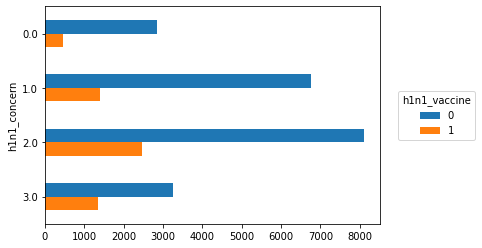

In [34]:
# h1n1_concern and h1n1_vaccine
counts = (joined_df[['h1n1_concern', 'h1n1_vaccine']]
              .groupby(['h1n1_concern', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine')
         )
print(counts)
ax = counts.plot.barh()
ax.invert_yaxis()
print(ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='h1n1_vaccine'
))

# since distinct h1n1_concern levels doesn't show musch of a difference, it is hard to say the h1n1 concern level's influence on the likelyhood of someone getting vaccinated.
# Hense the two classes are imblanced.

h1n1_concern
0.0     3296
1.0     8153
2.0    10575
3.0     4591
dtype: int64
h1n1_vaccine         0         1
h1n1_concern                    
0.0           0.864381  0.135619
1.0           0.828652  0.171348
2.0           0.766147  0.233853
3.0           0.707907  0.292093
Legend


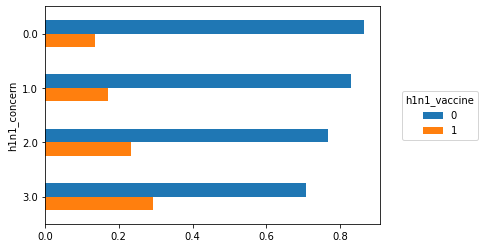

In [35]:
h1n1_concern_counts = counts.sum(axis='columns')
print(h1n1_concern_counts)
props = counts.div(h1n1_concern_counts, axis='index')
print(props)
ax = props.plot.barh()
ax.invert_yaxis()
print(ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
))

# It is evident that higher the concern it is more likely the vaccine has been injected.

## For other features

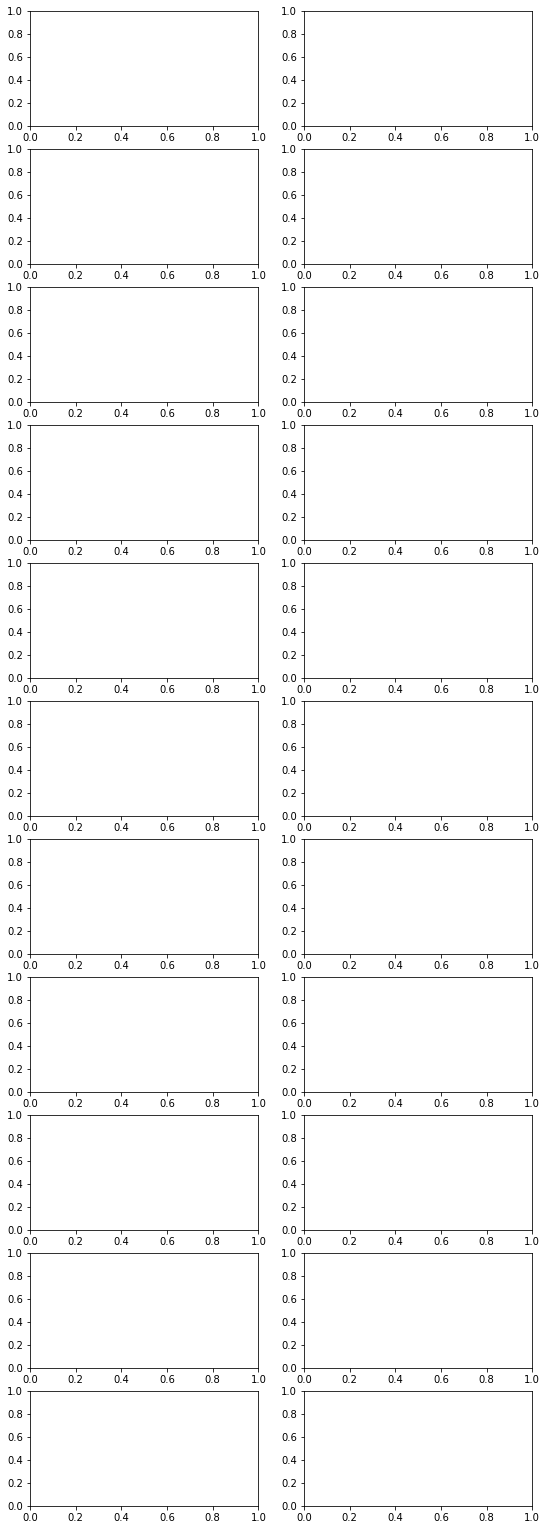

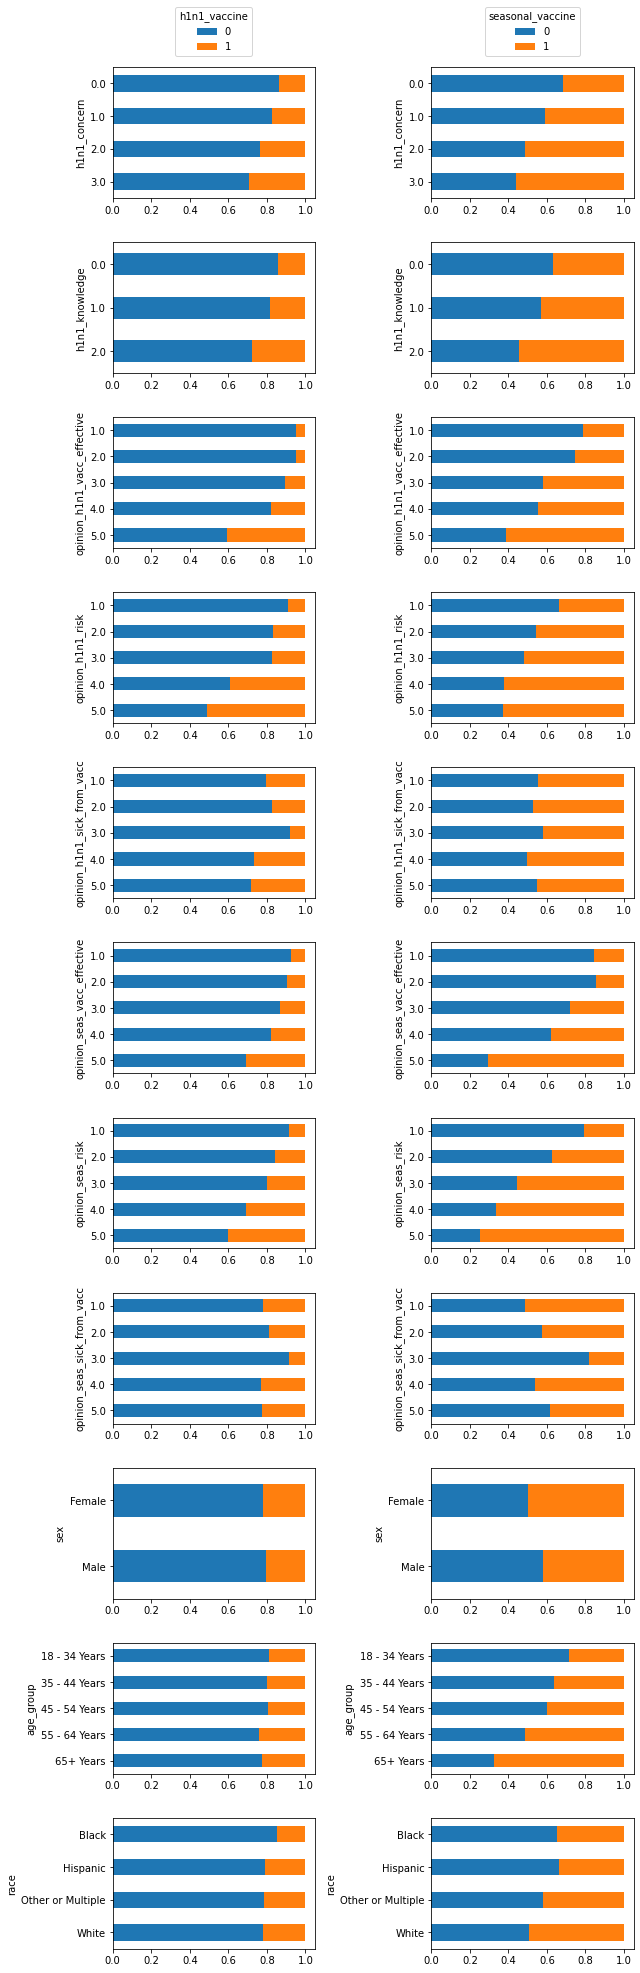

In [36]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (joined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', joined_df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

# demographic features have a strong correlation with seasonal_vaccine, but less with h1n1_vaccine. In particular,
# we see a strong realtionship of age_group with seasonal_vaccine but not with h1n1_vaccine.
# It appears that with seasonal flu, people act appropriately according to the fact that people more impacted and have higher risk of flu-related complications with age.
# It turns out though that H1N1 flu has an interesting relationship with age: even though older people have higher risk of complications, they were less likely to get infected! 
# it seems like the risk factors ended up being reflected in the vaccination rates.

# Preprocessing data

In [0]:
#create a pipeline to preprocess data
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler

numeric_cols = x_train.columns[x_train.dtypes != "object"].values
categorical_cols = x_train.columns[x_train.dtypes == "object"].values

numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', MinMaxScaler()),
    ('simple_imputer', SimpleImputer(strategy='mean'))
])

categorical_preprocessing_steps = Pipeline ([                               
    ('categorical_imputer', SimpleImputer(strategy ='constant')),
    ('encode', OneHotEncoder()),

])


preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("categorical",categorical_preprocessing_steps,categorical_cols)
    ],
    remainder = "drop"
)

# ML model creation and training

In [0]:
# Split training and test data
RANDOM_SEED = 6  
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2,
    shuffle=True,
    stratify=y_train,
    random_state=RANDOM_SEED) 

estimators = MultiOutputClassifier(estimator = RandomForestClassifier(n_estimators = 1000,max_depth=20))

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [39]:
full_pipeline.fit(X_train, Y_train)
preds = full_pipeline.predict_proba(X_test)
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = Y_test.index
)
print(roc_auc_score(Y_test, y_preds))


0.8624295662977677


In [0]:
test_probas = full_pipeline.predict_proba(x_test)
submission_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/dm-predict-h1n1/submission_format.csv", 
                            index_col="respondent_id")
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]
submission_df.to_csv('/content/drive/My Drive/Colab Notebooks/data/dm-predict-h1n1/random-forest-model.csv', index=True)
